In [1]:
from activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, normalizeZeroOne, get_input_output_shape
from models import SimpleCNN
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
from retinal_rl.analysis import statistics as ret_stats
import numpy as np

In [2]:
train_data = datasets.CIFAR10(root="../data", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=256, shuffle=False)

Files already downloaded and verified


In [3]:
model = SimpleCNN.load("../models/simple3layercnn")
model = model.get_sequential()
summary(model, (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 30, 30]           448
├─ReLU: 1-2                              [1, 16, 30, 30]           --
├─Conv2d: 1-3                            [1, 16, 28, 28]           2,320
├─ReLU: 1-4                              [1, 16, 28, 28]           --
├─Conv2d: 1-5                            [1, 16, 26, 26]           2,320
├─ReLU: 1-6                              [1, 16, 26, 26]           --
├─Flatten: 1-7                           [1, 10816]                --
├─Linear: 1-8                            [1, 10]                   108,170
├─Softmax: 1-9                           [1, 10]                   --
Total params: 113,258
Trainable params: 113,258
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.90
Input size (MB): 0.01
Forward/backward pass size (MB): 0.30
Params size (MB): 0.45
Estimated Total Si

100%|██████████| 32/32 [00:01<00:00, 19.44it/s]
/home/fabio/anaconda3/envs/retinal-rl/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


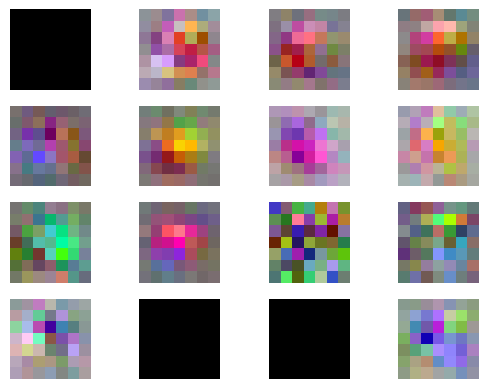

In [4]:
fig, axes = plt.subplots(4, 4)
eff_rfs = activation_triggered_average(model[:6], n_batch=8192, n_iter=32)
for eff_rf, ax in zip(eff_rfs, axes.flat):
    ax.imshow(normalizeZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')

100%|██████████| 128/128 [00:52<00:00,  2.41it/s]


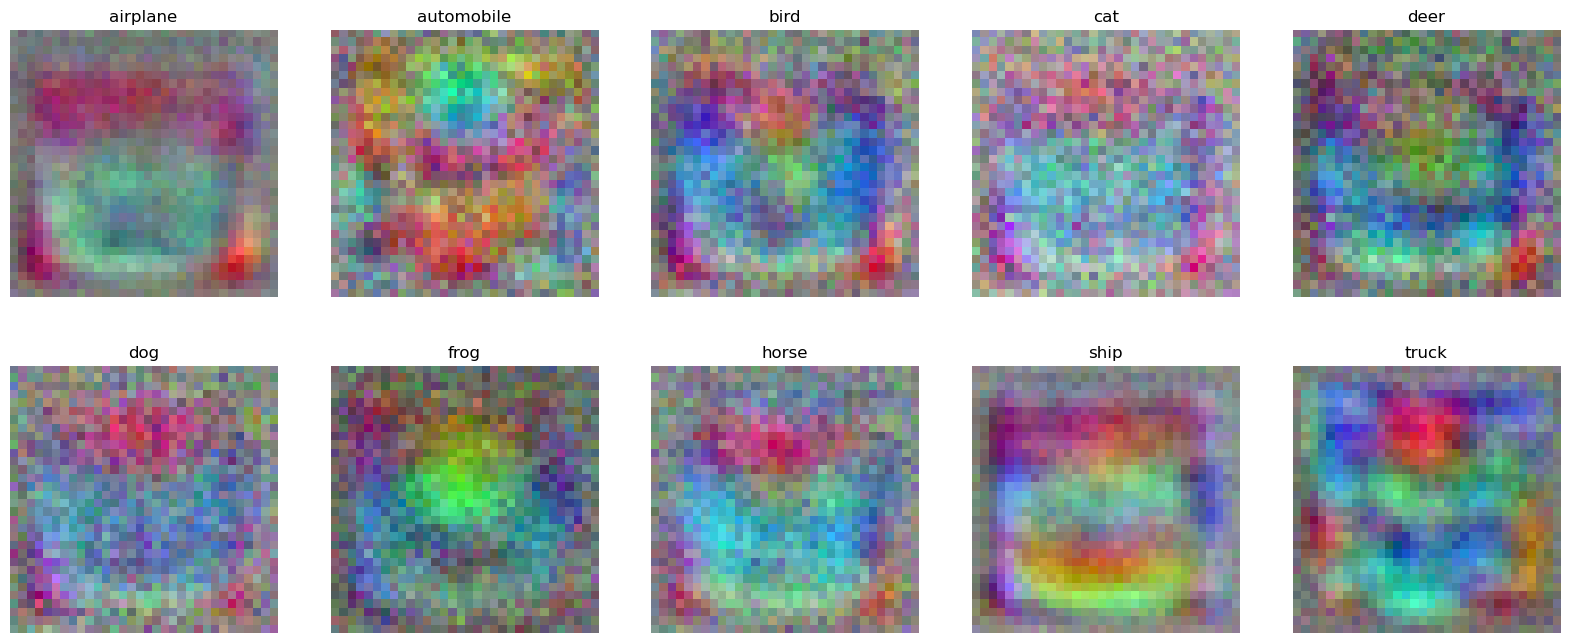

In [5]:
eff_rfs = activation_triggered_average(model, n_iter=128)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, i in train_data.class_to_idx.items():
    ax = axes.flat[i]
    ax.imshow(normalizeZeroOne(eff_rfs[i].movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)

100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


TypeError: can only concatenate tuple (not "str") to tuple

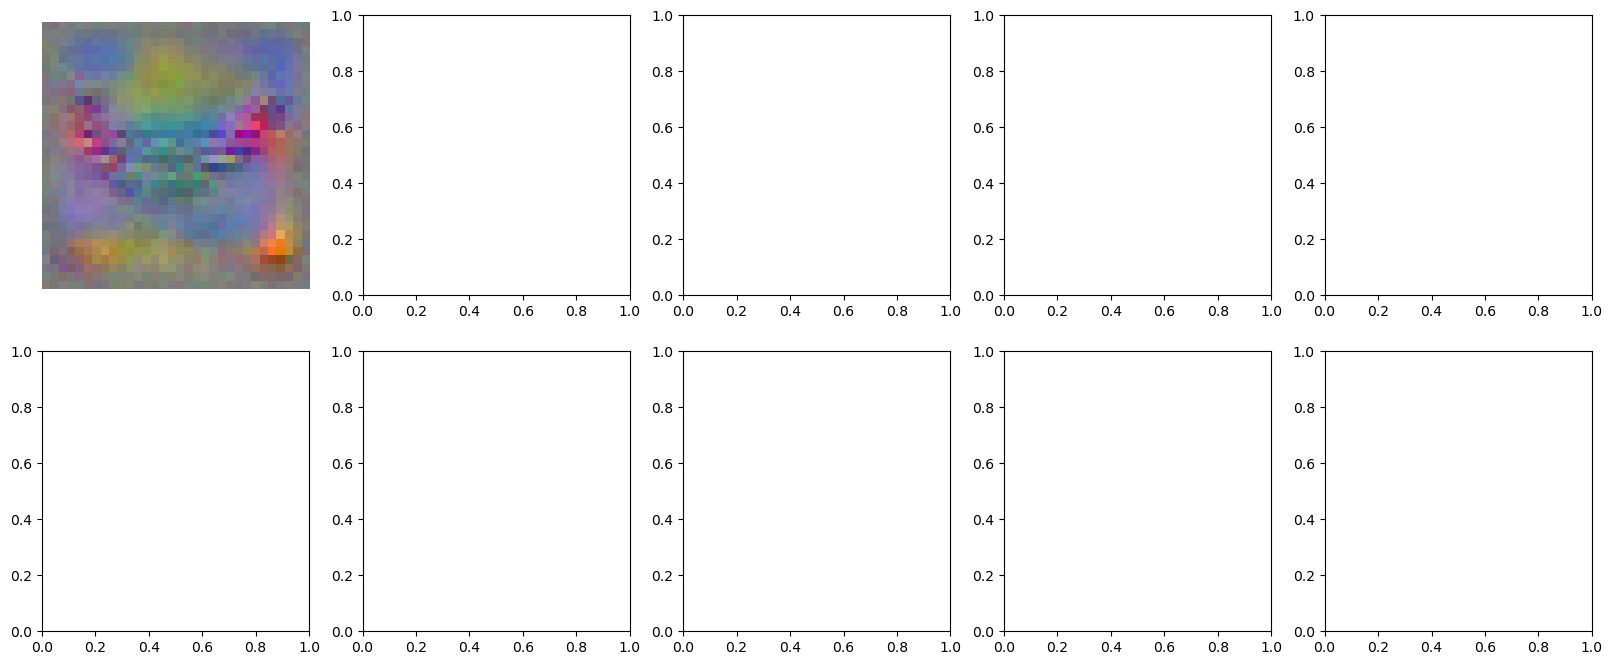

In [6]:
back_maxs = backprop_maximization(model, n_iter=2048, batch_size=16, reduction=True)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2))
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

In [9]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


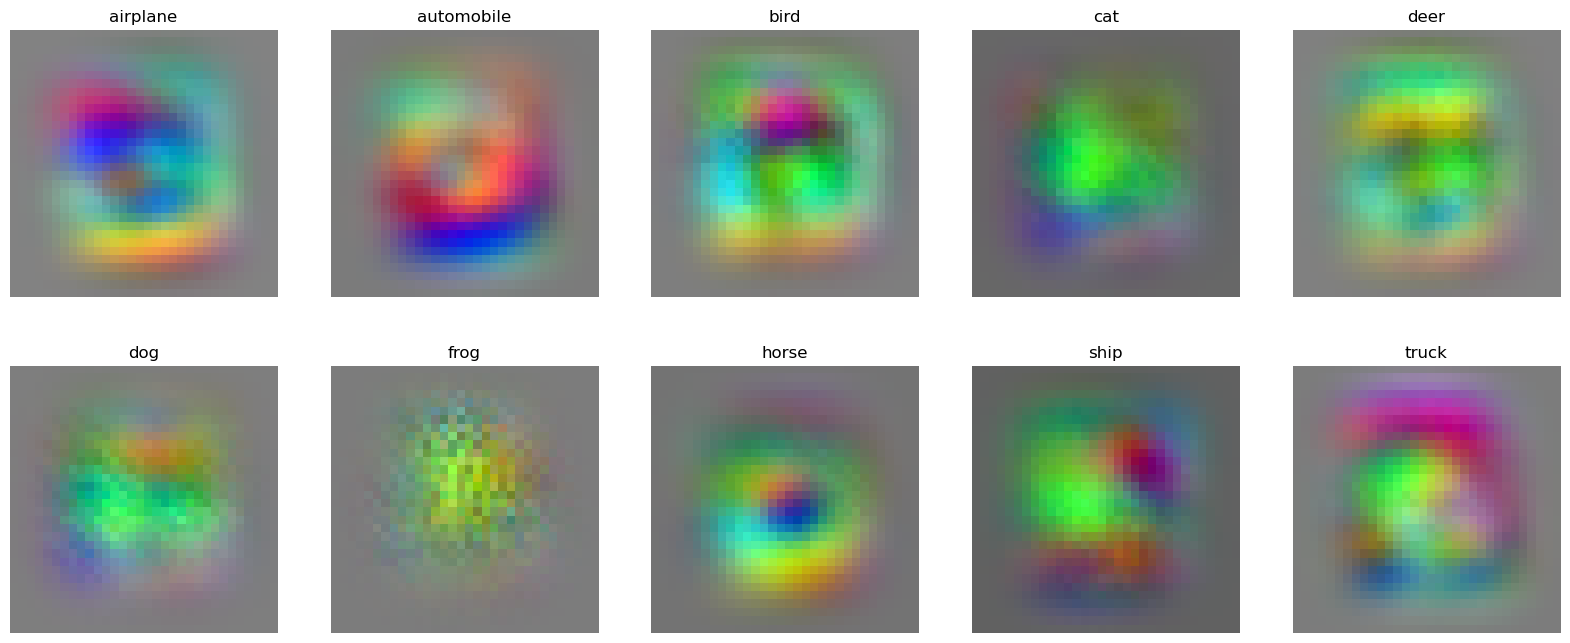

In [ ]:
eff_rfs = effective_receptive_field(model, n_batch=1024)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(eff_rf.movedim(0,2))
    ax.axis('off')
    ax.set_title(class_name)

In [ ]:
class Object(object):
    pass

# conv_head = torch.nn.Sequential()
# conv_head.append(model.conv1)
# conv_head.append(model.relu)
# for layer in model.extra_conv_layers:
#     conv_head.append(layer)
#     conv_head.append(model.relu)
# conv_head.append(model.fc)
conv_head=model[:-3]

cfg = Object()
cfg.device="cpu"
env = Object()
env.observation_space={"obs":eff_rf}
actor_critic=Object()
actor_critic.encoder = Object()
encoder = Object()
encoder.conv_head = conv_head
actor_critic.encoder.vision_model = encoder
nbtch = 1024
nreps = 16384//nbtch

In [ ]:
stas = ret_stats.gaussian_noise_stas(cfg,env,actor_critic,nbtch,nreps,prgrs=True)

Generating STAs:  60%|██████    | 96/160 [02:39<01:46,  1.66s/it]


In [ ]:
stas.keys()

dict_keys(['0', '1', '2', '4', '6', '8'])

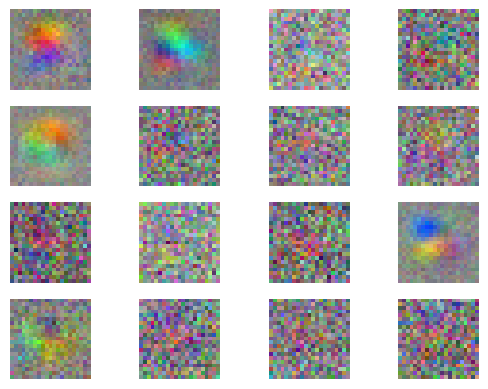

In [ ]:
fig, axes = plt.subplots(4, 4)
for sta, ax in zip(stas['8'], axes.flat):
    ax.imshow(np.moveaxis(normalizeZeroOne(sta),0,2))
    ax.axis('off')